In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import torch.nn as nn
from config import *
from load_data import getTrainingSet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class FeedForwardNN(nn.Module):
    def __init__(self, input_size, size_of_hidden_layers, output_size):
        super(FeedForwardNN, self).__init__()
        self.size_of_hidden_layers = size_of_hidden_layers
        self.fc1 = nn.Linear(input_size, size_of_hidden_layers[0])
        for i in range(1, len(size_of_hidden_layers)):
            setattr(
                self, f'fc{i+1}', nn.Linear(size_of_hidden_layers[i-1], size_of_hidden_layers[i]))

        self.out = nn.Linear(size_of_hidden_layers[-1], output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        for i in range(1, len(self.size_of_hidden_layers)):
            fc= getattr(self, f'fc{i+1}')
            x = self.relu(fc(x))
        x = self.out(x)
        return x

In [2]:

def train_model(model, train_loader, epochs, optimizer, loss_function, verbose=False, save_model=False):
    model.train()
    losses = []
    prt = True
    for epoch in range(epochs):
        epoch_losses = []
        outputs = []
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            if prt:
                print("x[0]",x[0])
            # unroll the sequence
            x = x.view(x.size(0), -1)
            output = model.forward(x)
            output = output.squeeze(1)
            if(prt):
                print("y",y)
                print("output",output)
                prt = False
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()
            if verbose and i % (x.size(0)*10) == 0:
                print(
                    f'Epoch {epoch} Batch {i//x.size(0)} loss: {loss.item()}')
            epoch_losses.append(loss.item())
            outputs.append(output)
        losses.append(np.mean(epoch_losses))
        print(f'Epoch {epoch} loss: {losses[-1]}')
    if save_model:
        torch.save(model.state_dict(), 'fnn_trained_model.pth')
    return losses, outputs

In [3]:
dataset = getTrainingSet(reshape=False, sequence_length=24)
features = len(dataset.X[0][0])
sequence_length = len(dataset.X[0])
input_size = features * sequence_length
size_of_hidden_layers = SIZE_OF_HIDDEN_LAYERS_FNN
output_size = OUTPUT_SIZE
epochs = EPOCHS_FNN
learning_rate = LEARNING_RATE
batch_size = BATCH_SIZE

model = FeedForwardNN(input_size, size_of_hidden_layers, output_size)
loss_function = nn.MSELoss()
adam = torch.optim.Adam(model.parameters(), lr=learning_rate)

   year  month  day  hour  NO1_temperature  consumption_t-1  NO1_consumption
1  2017      5    1     1              1.8      3325.431995      3344.690998
2  2017      5    1     2              3.2      3344.690998      3398.359002
3  2017      5    1     3              3.6      3398.359002      3430.220001
4  2017      5    1     4              3.4      3430.220001      3606.750000
5  2017      5    1     5              3.1      3606.750000      3739.876998


In [4]:

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=False)
losses, outputs = train_model(
    model,
    train_dataloader,
    epochs,
    adam,
    loss_function,
    verbose=False,
    save_model=True
)


x[0] tensor([[-1.5088, -0.4415, -1.6726, -1.5167, -0.6588, -0.5784],
        [-1.5088, -0.4415, -1.6726, -1.3722, -0.4881, -0.5641],
        [-1.5088, -0.4415, -1.6726, -1.2278, -0.4393, -0.5243],
        [-1.5088, -0.4415, -1.6726, -1.0833, -0.4637, -0.5007],
        [-1.5088, -0.4415, -1.6726, -0.9388, -0.5003, -0.3699],
        [-1.5088, -0.4415, -1.6726, -0.7943, -0.5003, -0.2712],
        [-1.5088, -0.4415, -1.6726, -0.6499, -0.4515, -0.1875],
        [-1.5088, -0.4415, -1.6726, -0.5054, -0.3296, -0.1016],
        [-1.5088, -0.4415, -1.6726, -0.3609, -0.2564, -0.0696],
        [-1.5088, -0.4415, -1.6726, -0.2165, -0.1589, -0.1258],
        [-1.5088, -0.4415, -1.6726, -0.0720,  0.2191, -0.2175],
        [-1.5088, -0.4415, -1.6726,  0.0725,  0.5118, -0.3071],
        [-1.5088, -0.4415, -1.6726,  0.2169,  0.5849, -0.3869],
        [-1.5088, -0.4415, -1.6726,  0.3614,  0.6825, -0.4497],
        [-1.5088, -0.4415, -1.6726,  0.5059,  0.7434, -0.4873],
        [-1.5088, -0.4415, -1.6726,

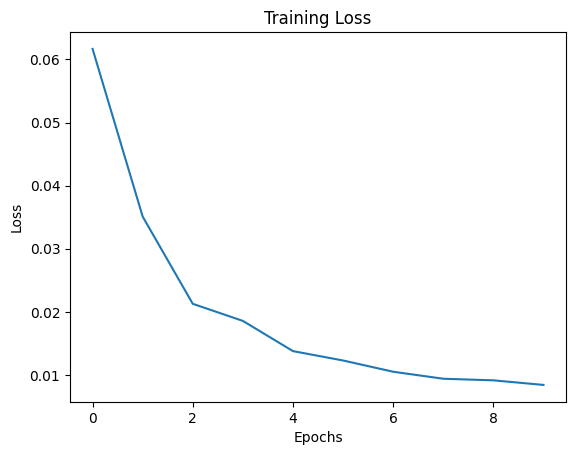

In [5]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [6]:
from load_data import getTestData
model.load_state_dict(torch.load('fnn_trained_model.pth'))

model.eval()

data = getTestData()

# print(data[0][0])
# print(data[1][:25])
data = (data[0].astype(np.float32), data[1])
def predict_one_horizon(model, X_test, given_cases,forecast_horizon):
    X_test = X_test.copy()
    predictions = []
    assert len(X_test) == forecast_horizon+given_cases
    # print("X_test[i:i+forecast_horizon]",X_test[:forecast_horizon])
    with torch.no_grad():
        for i in range(forecast_horizon):
            x = torch.tensor(X_test[i:i+forecast_horizon]).to(device)
            x = x.view(1, -1)
            output = model.forward(x)
            predictions.append(output.item())
            X_test[i+forecast_horizon][-1] = output.item()
    return predictions


preds=predict_one_horizon(model, data[0][:48], 24, 24)


   year  month  day  hour  NO1_temperature  consumption_t-1  NO1_consumption
1  2017      5    1     1              1.8      3325.431995      3344.690998
2  2017      5    1     2              3.2      3344.690998      3398.359002
3  2017      5    1     3              3.6      3398.359002      3430.220001
4  2017      5    1     4              3.4      3430.220001      3606.750000
5  2017      5    1     5              3.1      3606.750000      3739.876998


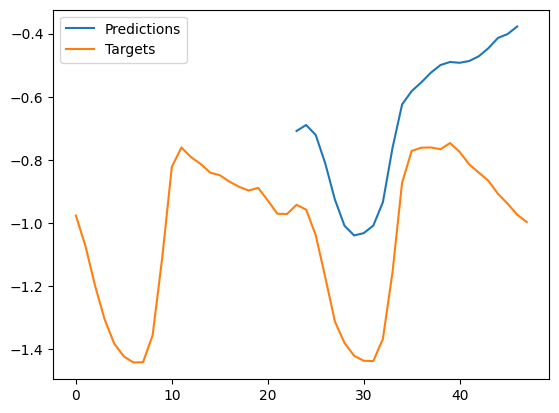

In [7]:
def plot_predictions(predictions, targets):
    
    plt.plot([i for i in range(23,47)], predictions, label='Predictions')
    
    plt.plot(targets[0:48], label='Targets')
    plt.legend()
    plt.show()
    
plot_predictions(preds, data[1])

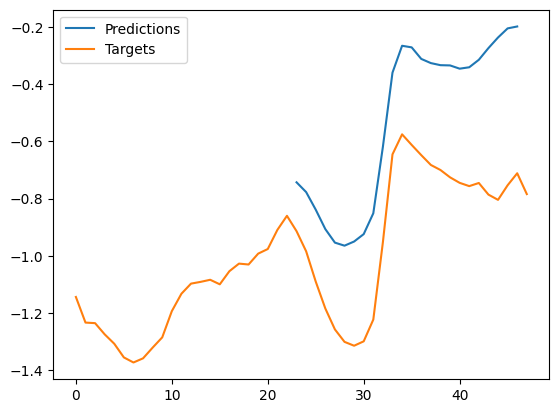

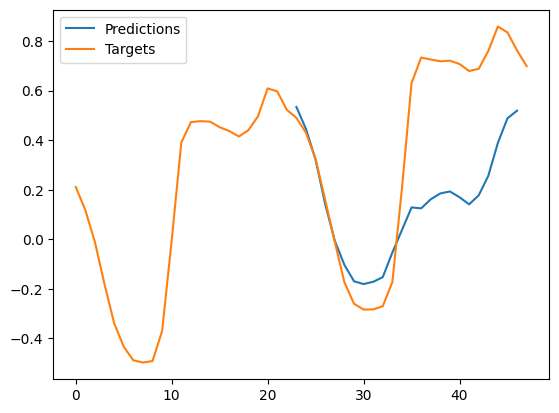

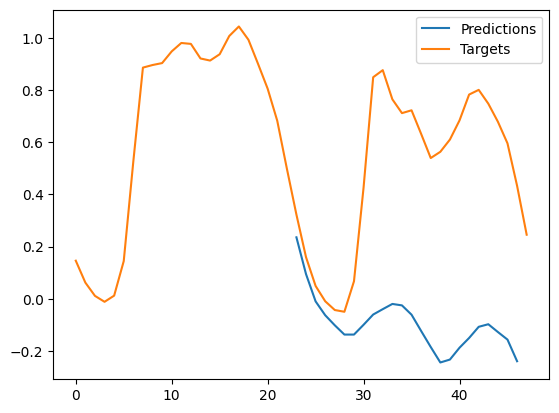

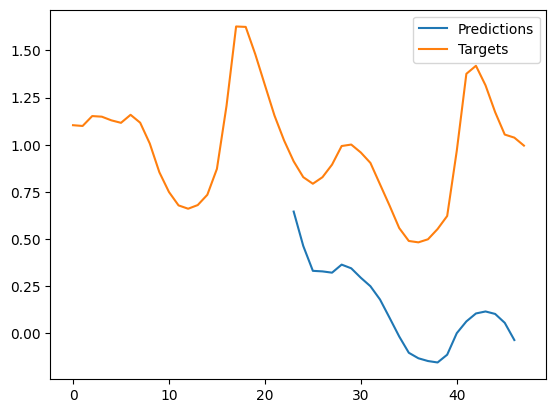

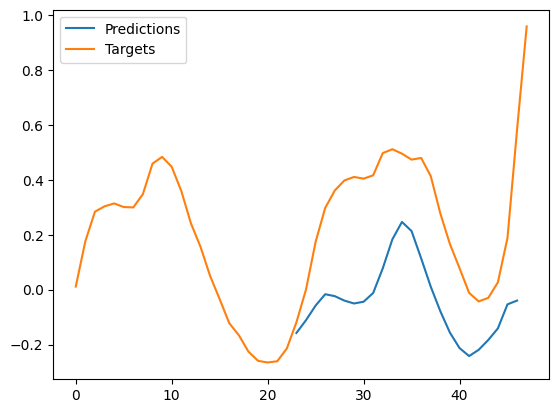

0.29507331402374387


In [8]:
import random
def average_error_over_horizons(model, X_test, y_test, forecast_horizon):
    errors = []
    random.seed(42)
    random_numbers = random.sample(range(len(X_test)-2*forecast_horizon), 5)
    
    for i in range(len(X_test)-2*forecast_horizon):
        preds = predict_one_horizon(model, X_test[i:i+2*forecast_horizon], given_cases=forecast_horizon, forecast_horizon=forecast_horizon)
        error = np.mean(np.square(preds-y_test[i+forecast_horizon-1:i+2*forecast_horizon-1]))
        errors.append(error)
        if i in random_numbers:
            plot_predictions(preds, y_test[i:i+2*forecast_horizon])
    return np.mean(errors)

print(average_error_over_horizons(model, data[0], data[1], 24))